# Grouped By Graph Type CNN Model With Contamination Using Scanpaths With 3x3 Kernel

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Scanpaths" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Scanpaths" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Scanpaths")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Scanpaths/organized_by_graph_type_contaminated (at project root)
base_dataset_path = os.path.join(project_root, "Scanpaths", "organized_by_graph_type_contaminated")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [3]:
# Function to create your original CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(img_height, img_width, 1)),  # Grayscale input

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # Convert RGB to grayscale
    def convert_to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        return image, label

    train_ds = train_ds.map(convert_to_grayscale)
    val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")


=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 894ms/step - accuracy: 0.5068 - loss: 290.1596 - val_accuracy: 0.5355 - val_loss: 0.6922
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 803ms/step - accuracy: 0.5529 - loss: 0.7479 - val_accuracy: 0.5355 - val_loss: 0.6930
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 807ms/step - accuracy: 0.6001 - loss: 0.6967 - val_accuracy: 0.5097 - val_loss: 0.6911
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 897ms/step - accuracy: 0.5996 - loss: 0.7664 - val_accuracy: 0.5548 - val_loss: 0.6912
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 846ms/step - accuracy: 0.6089 - loss: 0.6746 - val_accuracy: 0.5613 - val_loss: 0.6922
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 820ms/step - accuracy: 0.6651 - loss: 0.6228 - val_accuracy: 0.6645 - val_loss: 0.6897
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 800m

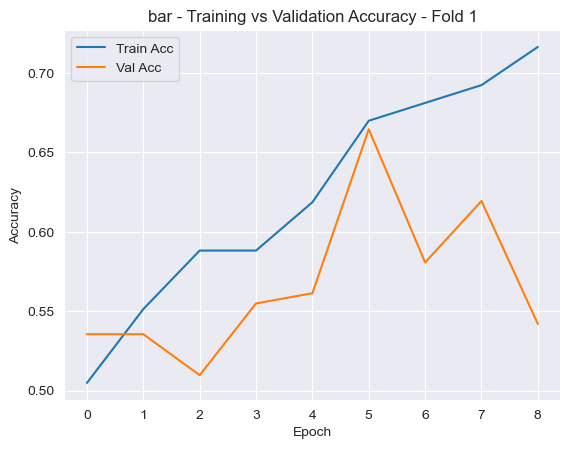

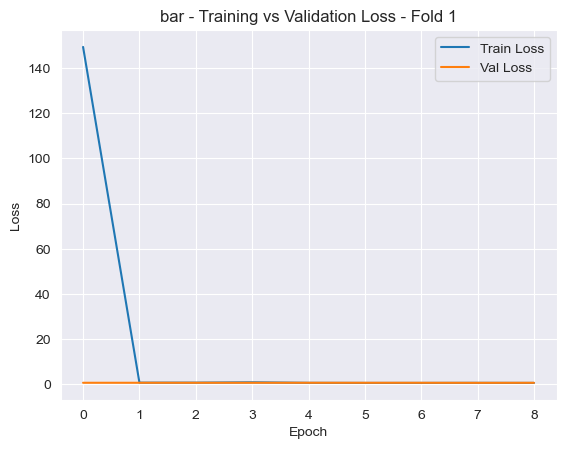

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


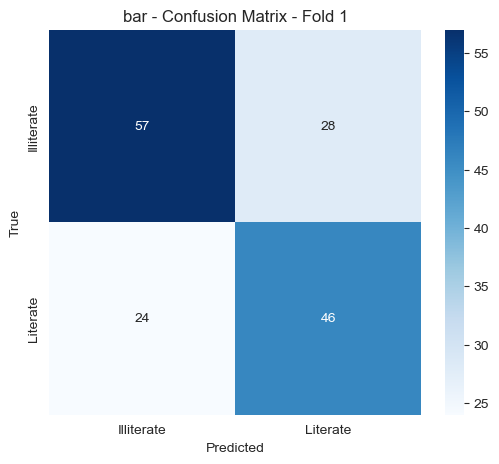

Fold 1 Final Train Acc: 0.7163, Final Val Acc: 0.5419
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 801ms/step - accuracy: 0.5198 - loss: 629.9538 - val_accuracy: 0.5548 - val_loss: 0.6866
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 929ms/step - accuracy: 0.5542 - loss: 0.6973 - val_accuracy: 0.5484 - val_loss: 0.6923
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 792ms/step - accuracy: 0.6451 - loss: 0.6798 - val_accuracy: 0.6000 - val_loss: 0.6588
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 782ms/step - accuracy: 0.6739 - loss: 0.6595 - val_accuracy: 0.5677 - val_loss: 0.6856
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - accuracy: 0.5908 - loss: 0.7430 - val_accuracy: 0.5484 - val_loss: 0.6923
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 786ms/step - accuracy: 0.6170 - loss: 0.6847 - val_accuracy: 0.5484 - val_loss: 0.6889


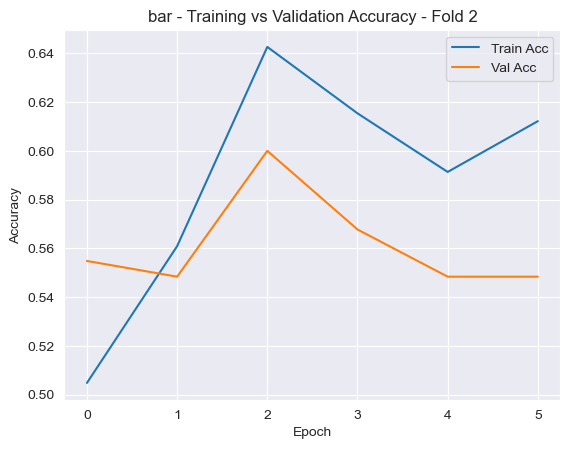

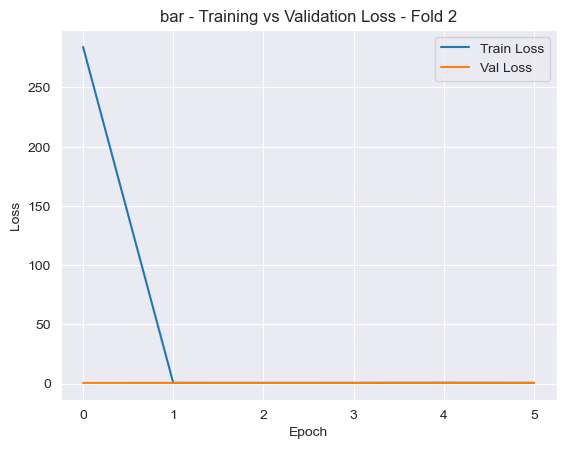

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


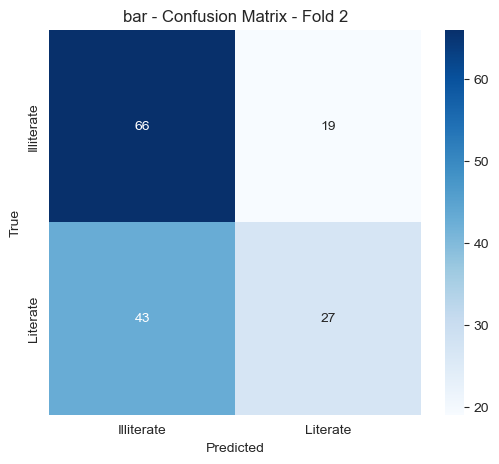

Fold 2 Final Train Acc: 0.6122, Final Val Acc: 0.5484
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 794ms/step - accuracy: 0.5216 - loss: 287.8098 - val_accuracy: 0.5935 - val_loss: 0.6772
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 816ms/step - accuracy: 0.5684 - loss: 0.6818 - val_accuracy: 0.5677 - val_loss: 0.6921
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 799ms/step - accuracy: 0.6164 - loss: 0.6836 - val_accuracy: 0.5419 - val_loss: 0.6913
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 814ms/step - accuracy: 0.6087 - loss: 0.6882 - val_accuracy: 0.5355 - val_loss: 0.6915


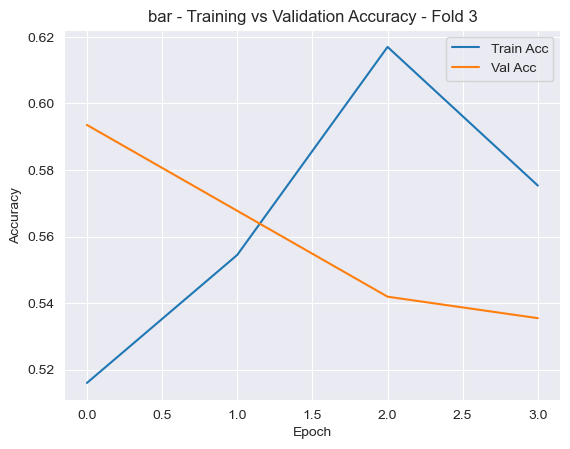

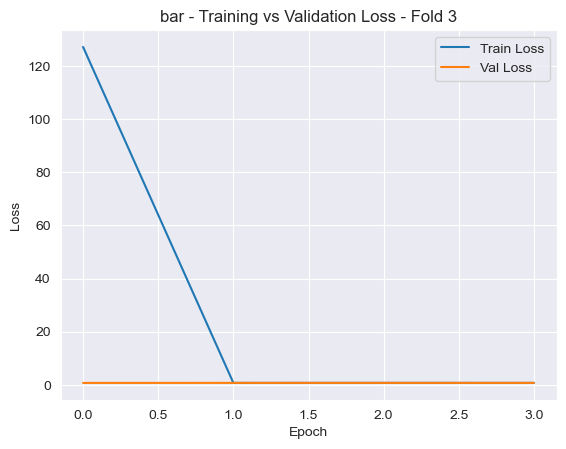

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


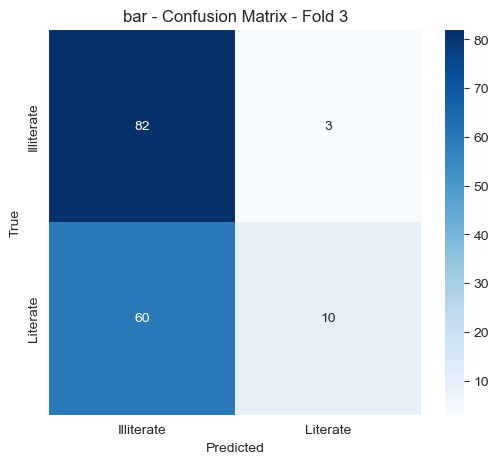

Fold 3 Final Train Acc: 0.5753, Final Val Acc: 0.5355
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 806ms/step - accuracy: 0.5212 - loss: 422.7162 - val_accuracy: 0.5419 - val_loss: 0.7070
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 842ms/step - accuracy: 0.5351 - loss: 0.7541 - val_accuracy: 0.6129 - val_loss: 0.6901
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 807ms/step - accuracy: 0.6609 - loss: 0.6708 - val_accuracy: 0.5935 - val_loss: 0.6660
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 789ms/step - accuracy: 0.7455 - loss: 0.6460 - val_accuracy: 0.6387 - val_loss: 0.6552
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 779ms/step - accuracy: 0.7736 - loss: 0.5227 - val_accuracy: 0.6581 - val_loss: 0.6309
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 796ms/step - accuracy: 0.7919 - loss: 0.4890 - val_accuracy: 0.6581 - val_loss: 0.6333
Epoch 7/10
20/20 ━━━━━━━━━━━

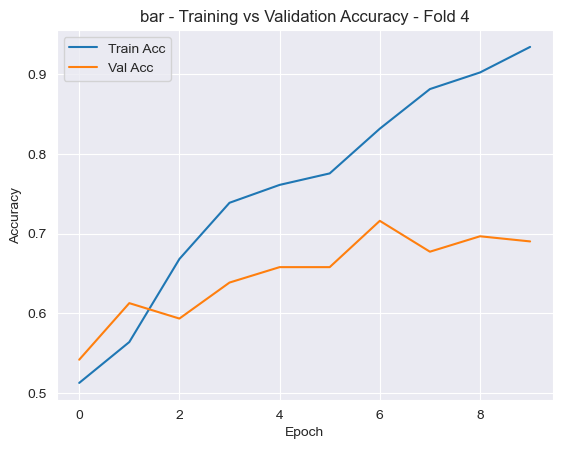

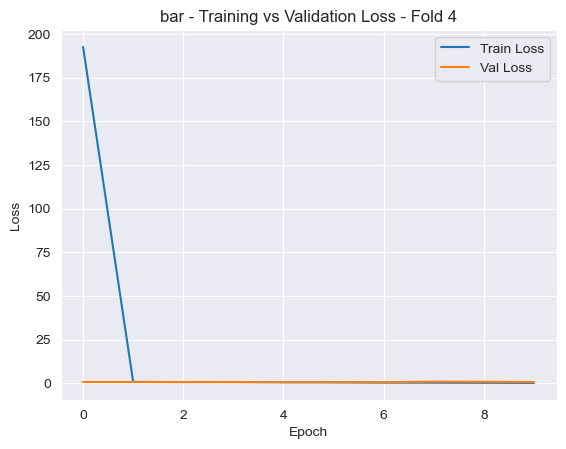

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


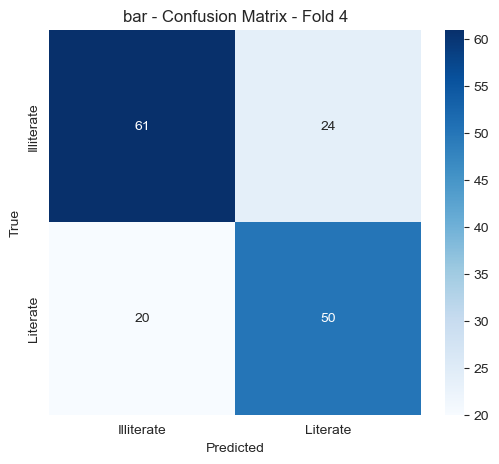

Fold 4 Final Train Acc: 0.9343, Final Val Acc: 0.6903
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 799ms/step - accuracy: 0.4969 - loss: 273.6949 - val_accuracy: 0.5871 - val_loss: 0.6918
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 808ms/step - accuracy: 0.6178 - loss: 0.6946 - val_accuracy: 0.5871 - val_loss: 0.6821
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 812ms/step - accuracy: 0.6612 - loss: 0.6424 - val_accuracy: 0.6194 - val_loss: 0.6454
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 784ms/step - accuracy: 0.7052 - loss: 0.6045 - val_accuracy: 0.6452 - val_loss: 0.6378
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 792ms/step - accuracy: 0.7393 - loss: 0.5329 - val_accuracy: 0.6323 - val_loss: 0.6311
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 832ms/step - accuracy: 0.7922 - loss: 0.4560 - val_accuracy: 0.6968 - val_loss: 0.6607
Epoch 7/10
20/20 ━━━━━━━━━━━

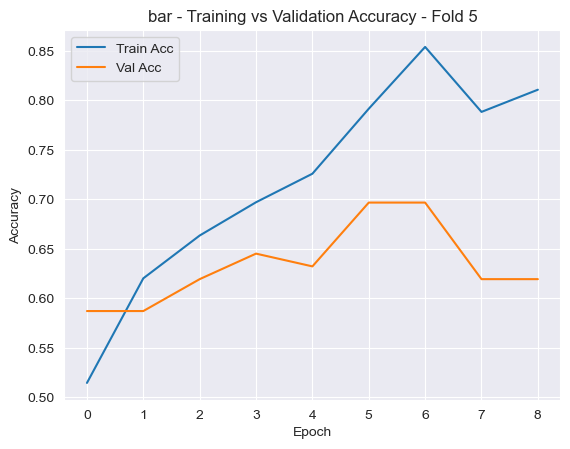

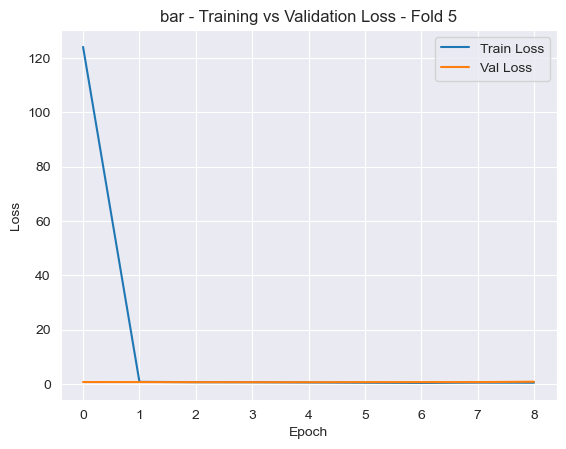

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


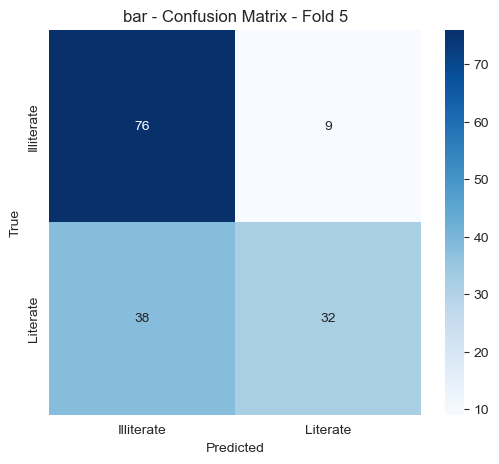

Fold 5 Final Train Acc: 0.8109, Final Val Acc: 0.6194

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 769ms/step - accuracy: 0.4429 - loss: 850.1080 - val_accuracy: 0.5965 - val_loss: 0.8435
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 798ms/step - accuracy: 0.5661 - loss: 3.8508 - val_accuracy: 0.6316 - val_loss: 0.6628
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 770ms/step - accuracy: 0.6483 - loss: 0.6316 - val_accuracy: 0.6667 - val_loss: 0.6105
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 792ms/step - accuracy: 0.6731 - loss: 0.7033 - val_accuracy: 0.6140 - val_loss: 0.6512
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - accuracy: 0.6979 - loss: 0.6239 - val_accuracy: 0.5965 - val_loss: 1.0917
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 793ms/step - accuracy: 0.7617 - loss: 0.5453 - val_accuracy: 0.7368 - val_loss

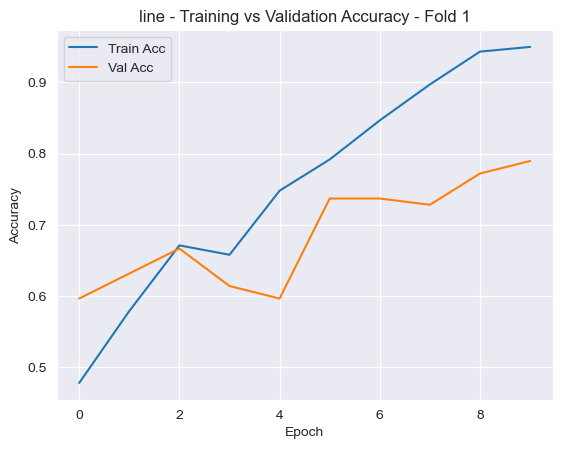

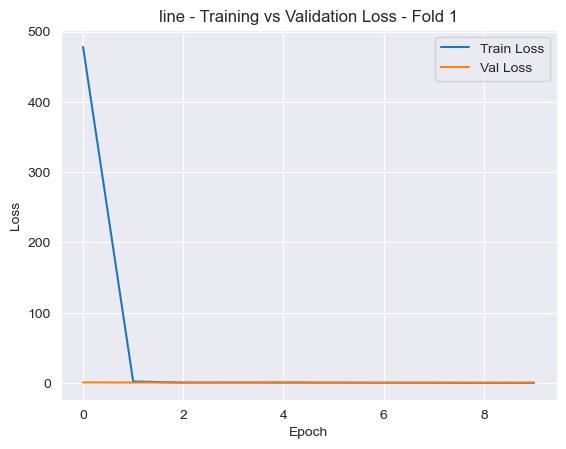

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


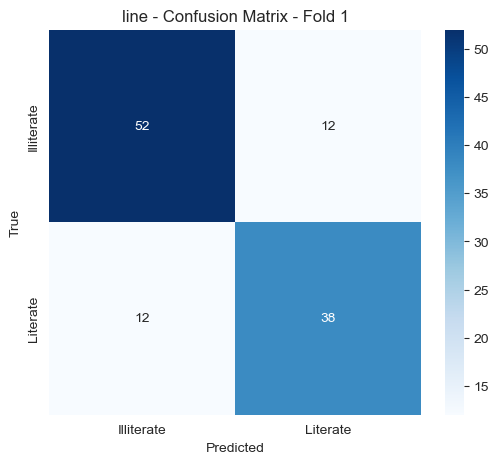

Fold 1 Final Train Acc: 0.9496, Final Val Acc: 0.7895
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 794ms/step - accuracy: 0.4404 - loss: 797.3821 - val_accuracy: 0.5614 - val_loss: 0.7335
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 801ms/step - accuracy: 0.5504 - loss: 0.8428 - val_accuracy: 0.4386 - val_loss: 0.9224
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - accuracy: 0.5552 - loss: 0.7621 - val_accuracy: 0.5614 - val_loss: 0.6861
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.5540 - loss: 0.6965 - val_accuracy: 0.5614 - val_loss: 0.6875


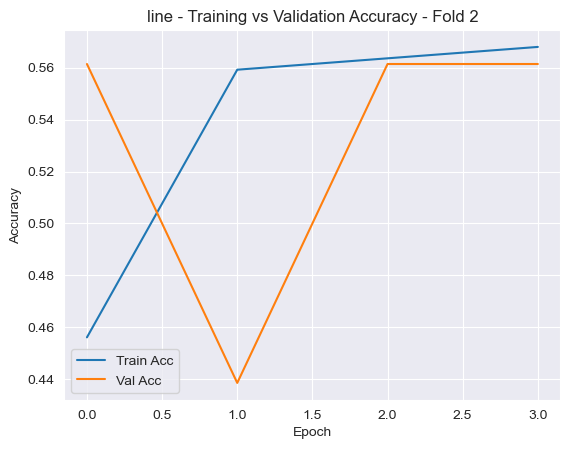

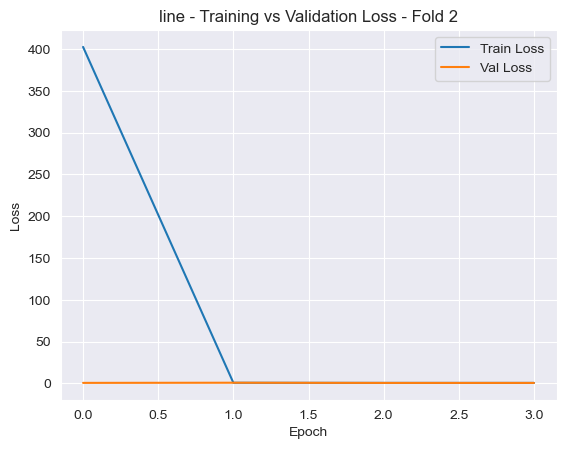

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


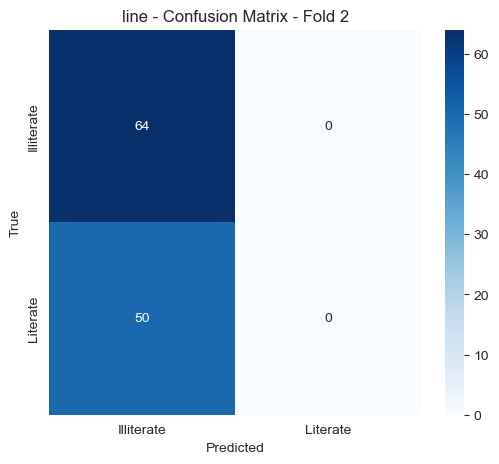

Fold 2 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 779ms/step - accuracy: 0.4645 - loss: 748.0768 - val_accuracy: 0.5614 - val_loss: 2.0506
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 824ms/step - accuracy: 0.5420 - loss: 1.6995 - val_accuracy: 0.5351 - val_loss: 0.6930
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 799ms/step - accuracy: 0.5596 - loss: 0.6890 - val_accuracy: 0.5614 - val_loss: 0.7534
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 764ms/step - accuracy: 0.6219 - loss: 0.6990 - val_accuracy: 0.5614 - val_loss: 1.0771


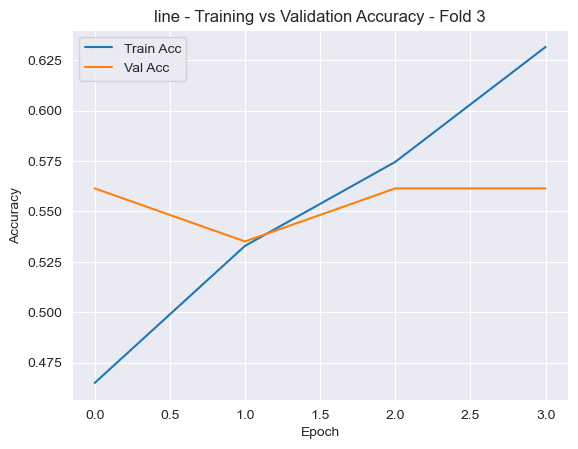

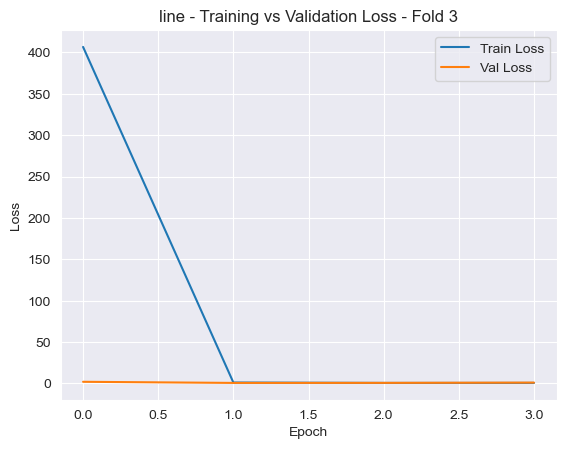

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


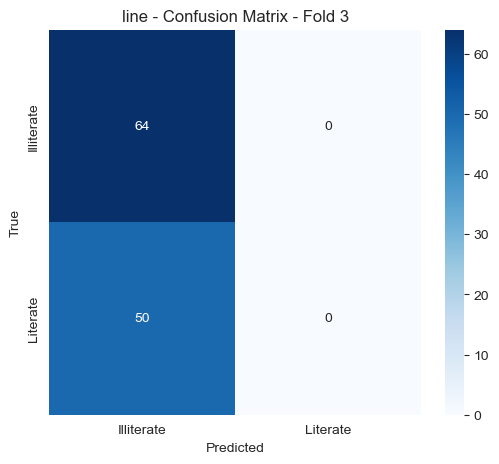

Fold 3 Final Train Acc: 0.6316, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 797ms/step - accuracy: 0.4135 - loss: 585.3414 - val_accuracy: 0.4561 - val_loss: 0.7519
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 824ms/step - accuracy: 0.5853 - loss: 1.4049 - val_accuracy: 0.5614 - val_loss: 0.6792
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 785ms/step - accuracy: 0.6135 - loss: 0.6925 - val_accuracy: 0.7281 - val_loss: 0.5859
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - accuracy: 0.6821 - loss: 0.5975 - val_accuracy: 0.7193 - val_loss: 0.5724
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 756ms/step - accuracy: 0.7688 - loss: 0.5010 - val_accuracy: 0.7281 - val_loss: 0.5593
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 783ms/step - accuracy: 0.8585 - loss: 0.3333 - val_accuracy: 0.7368 - val_loss: 0.6446
Epoch 7/10
15/15 ━━━━━━━━━━━

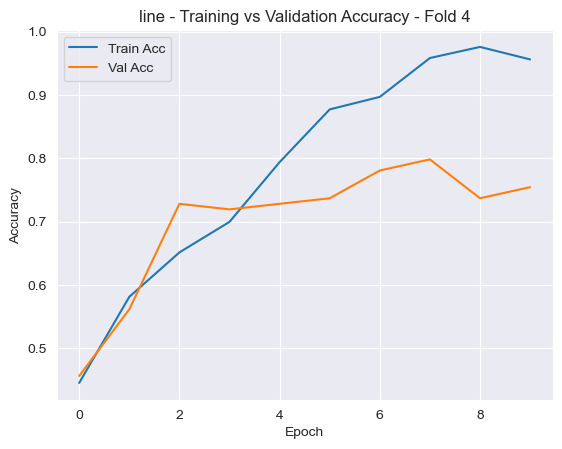

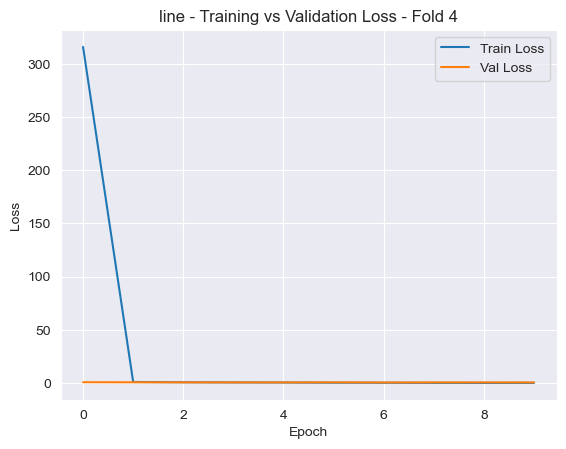

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


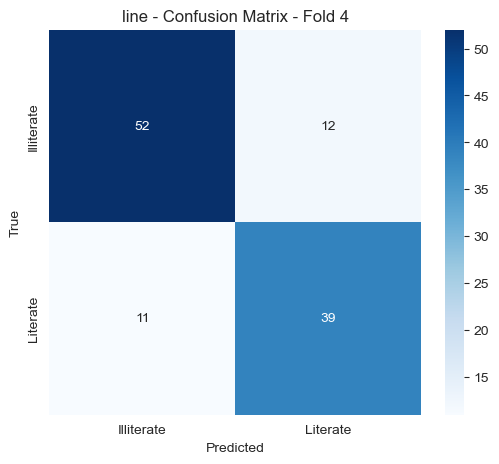

Fold 4 Final Train Acc: 0.9561, Final Val Acc: 0.7544
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 777ms/step - accuracy: 0.4539 - loss: 976.0696 - val_accuracy: 0.6053 - val_loss: 0.6912
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 842ms/step - accuracy: 0.6007 - loss: 0.6895 - val_accuracy: 0.5789 - val_loss: 0.6789
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 761ms/step - accuracy: 0.6330 - loss: 0.6816 - val_accuracy: 0.5351 - val_loss: 0.6897
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 766ms/step - accuracy: 0.6153 - loss: 0.7653 - val_accuracy: 0.5614 - val_loss: 0.6907


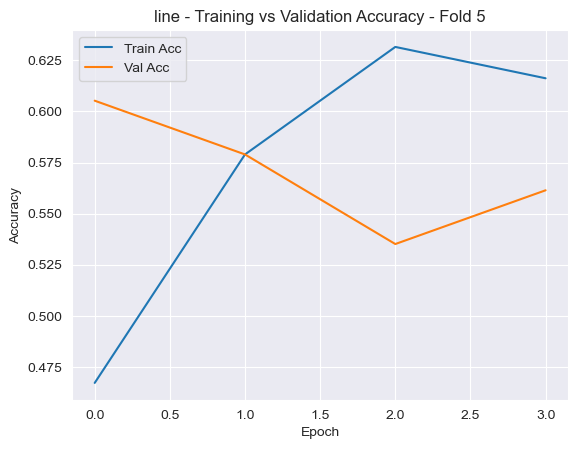

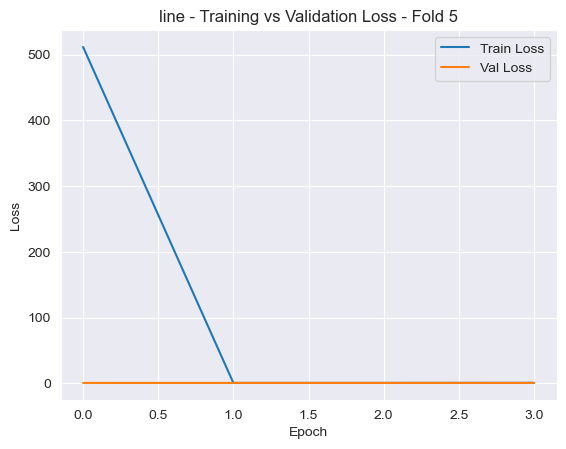

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


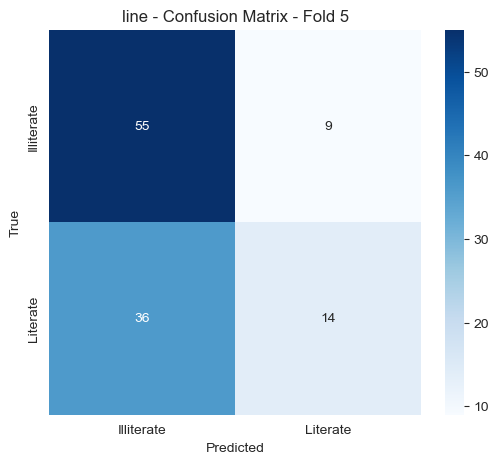

Fold 5 Final Train Acc: 0.6162, Final Val Acc: 0.5614

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 842ms/step - accuracy: 0.5850 - loss: 1256.6003 - val_accuracy: 0.6000 - val_loss: 63.3304
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.4933 - loss: 155.5880 - val_accuracy: 0.4000 - val_loss: 5.3408
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 772ms/step - accuracy: 0.5300 - loss: 13.9187 - val_accuracy: 0.7000 - val_loss: 0.8515
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6969 - loss: 1.0644 - val_accuracy: 0.4000 - val_loss: 1.2003
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 779ms/step - accuracy: 0.7721 - loss: 0.4510 - val_accuracy: 0.6667 - val_loss: 0.6143
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.8808 - loss: 0.3595 - val_accuracy: 0.4333 - val_loss: 2.3682


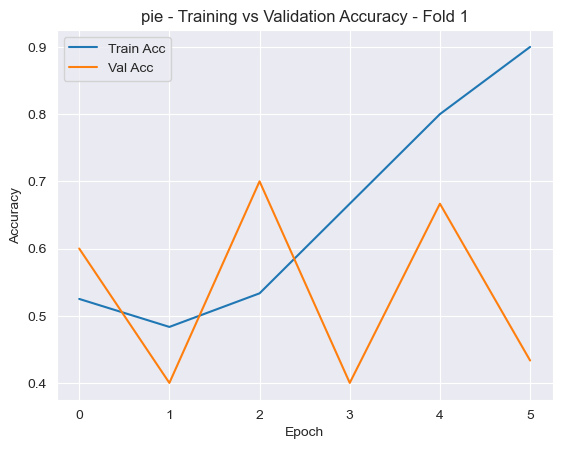

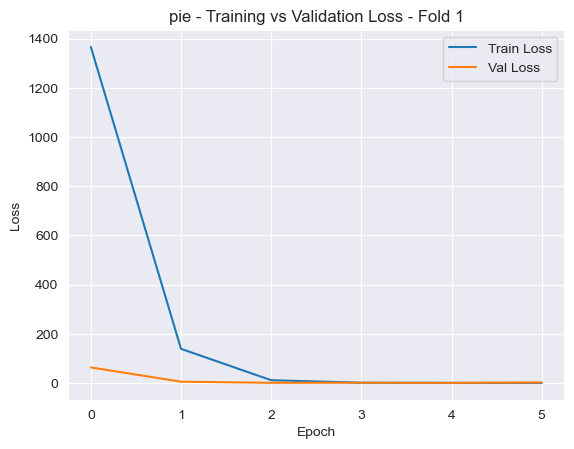

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


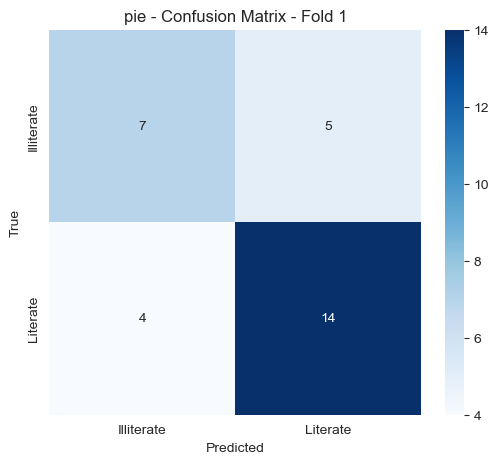

Fold 1 Final Train Acc: 0.9000, Final Val Acc: 0.4333
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 910ms/step - accuracy: 0.4142 - loss: 797.6760 - val_accuracy: 0.6000 - val_loss: 40.9960
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.4573 - loss: 46.8135 - val_accuracy: 0.6000 - val_loss: 4.6523
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step - accuracy: 0.4923 - loss: 10.6233 - val_accuracy: 0.4000 - val_loss: 1.5004
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step - accuracy: 0.4850 - loss: 2.2365 - val_accuracy: 0.4000 - val_loss: 0.8582


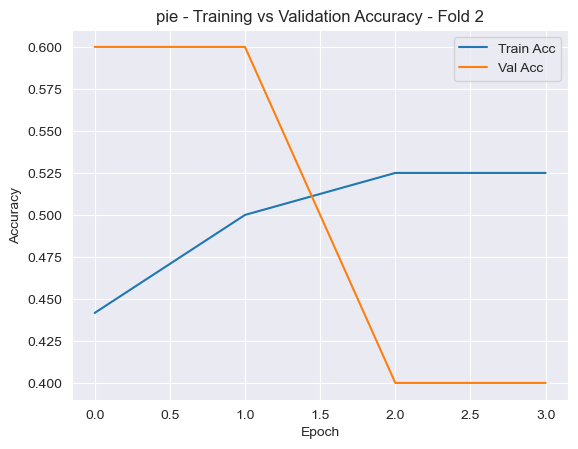

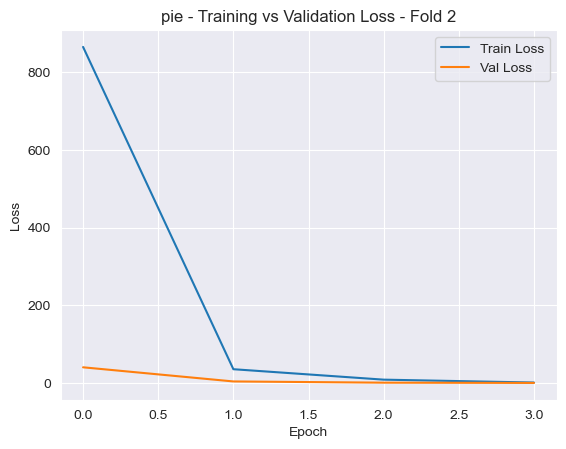

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


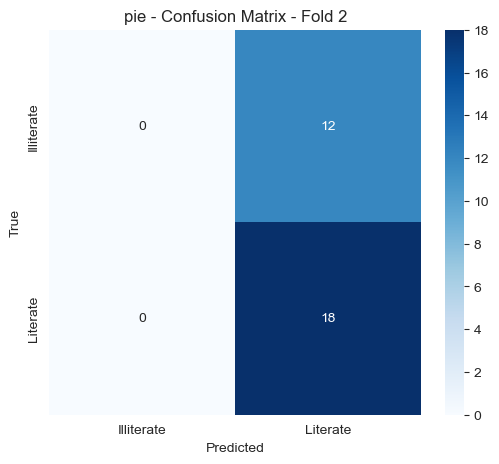

Fold 2 Final Train Acc: 0.5250, Final Val Acc: 0.4000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5177 - loss: 676.8014 - val_accuracy: 0.4000 - val_loss: 85.7123
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 787ms/step - accuracy: 0.5233 - loss: 79.8354 - val_accuracy: 0.4000 - val_loss: 92.8377
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 777ms/step - accuracy: 0.6450 - loss: 47.4182 - val_accuracy: 0.6000 - val_loss: 6.8392
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 893ms/step - accuracy: 0.4075 - loss: 7.5073 - val_accuracy: 0.4000 - val_loss: 13.9171
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step - accuracy: 0.5785 - loss: 8.2307 - val_accuracy: 0.4000 - val_loss: 16.5172
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 772ms/step - accuracy: 0.6577 - loss: 7.3499 - val_accuracy: 0.6000 - val_loss: 1.4952


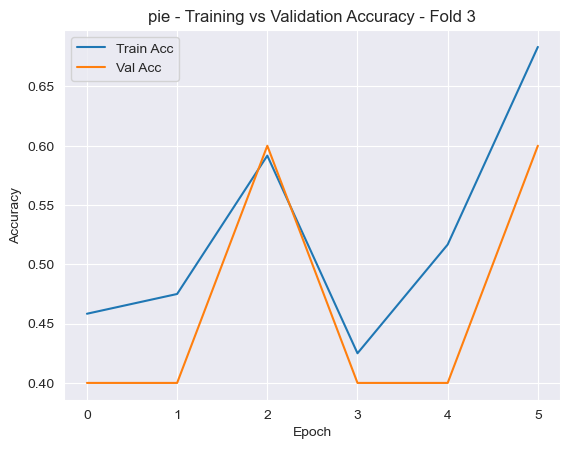

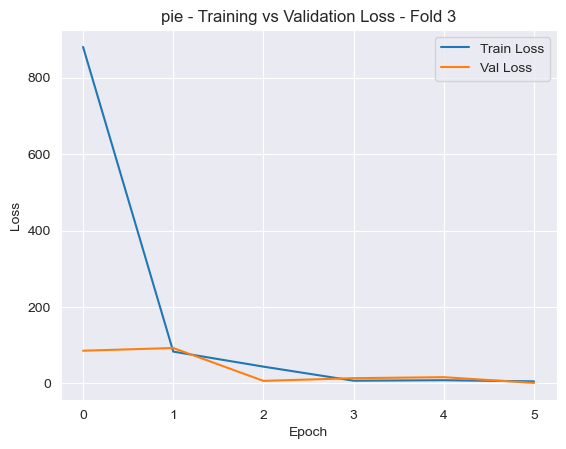

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


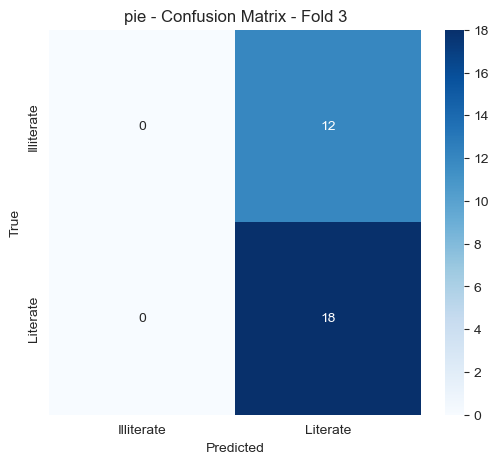

Fold 3 Final Train Acc: 0.6833, Final Val Acc: 0.6000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 832ms/step - accuracy: 0.6388 - loss: 331.3148 - val_accuracy: 0.6000 - val_loss: 295.0407
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 781ms/step - accuracy: 0.4602 - loss: 237.7746 - val_accuracy: 0.6000 - val_loss: 15.2032
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step - accuracy: 0.4148 - loss: 18.1219 - val_accuracy: 0.4000 - val_loss: 0.9419
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step - accuracy: 0.5575 - loss: 2.4230 - val_accuracy: 0.6000 - val_loss: 0.6714


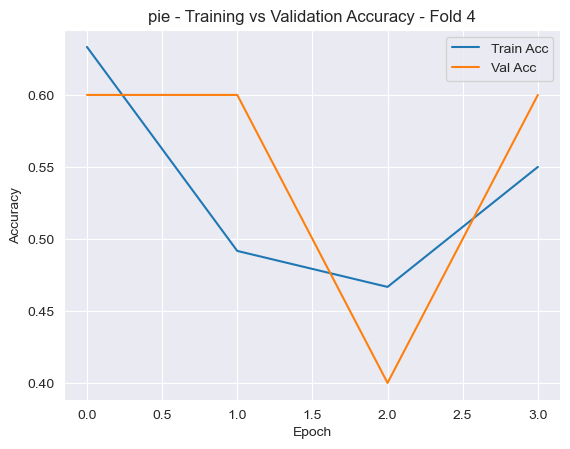

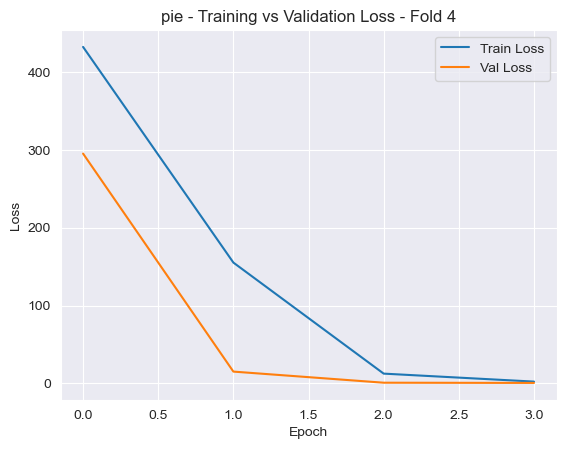

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


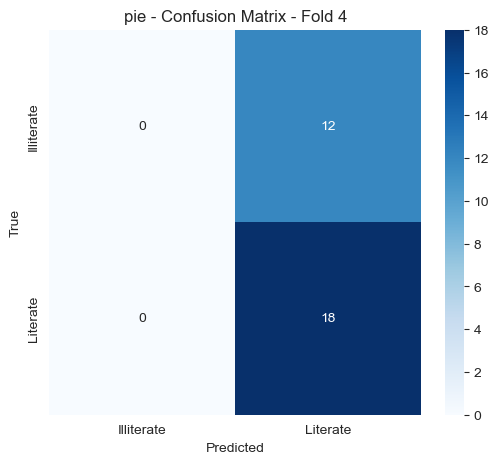

Fold 4 Final Train Acc: 0.5500, Final Val Acc: 0.6000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 894ms/step - accuracy: 0.4552 - loss: 1054.3801 - val_accuracy: 0.6000 - val_loss: 98.0752
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 900ms/step - accuracy: 0.5546 - loss: 107.7074 - val_accuracy: 0.6000 - val_loss: 0.6381
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 768ms/step - accuracy: 0.4908 - loss: 13.9767 - val_accuracy: 0.6000 - val_loss: 12.4244
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4454 - loss: 10.4275 - val_accuracy: 0.6000 - val_loss: 0.6751


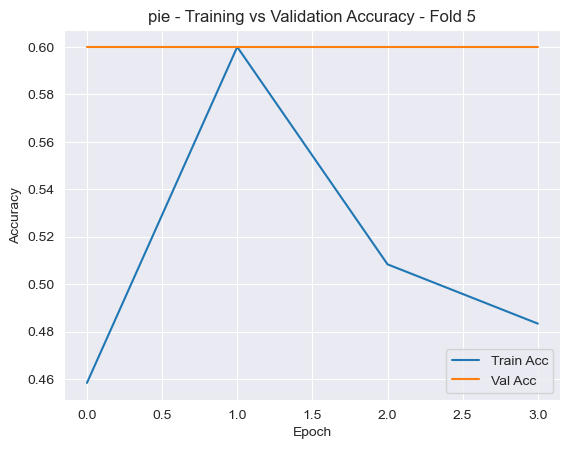

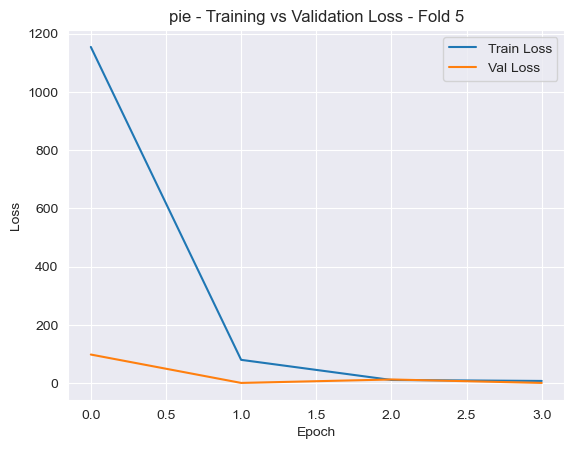

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


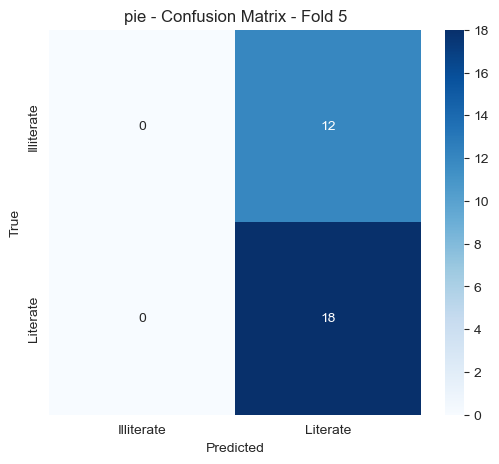

Fold 5 Final Train Acc: 0.4833, Final Val Acc: 0.6000


In [5]:
# Track results for all datasets
all_results = {}

# Perform training and collect fold-wise accuracies
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Compute and store means
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [6]:
# Print summary after all training is done
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.7298
→ Average Validation Accuracy: 0.5871

Graph Type: line
→ Average Train Accuracy: 0.7443
→ Average Validation Accuracy: 0.6456

Graph Type: pie
→ Average Train Accuracy: 0.6283
→ Average Validation Accuracy: 0.5267
